Bước 1: Phân chia tập dữ liệu cho train, valid, test (80% cho train, 20% cho valid và test)

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Đường dẫn tới dữ liệu gốc
original_data_dir = "/kaggle/input/data-phan-loai-04/data_phan_loai_03"

# Đường dẫn tới thư mục output cho tập huấn luyện và kiểm tra
train_dir = "/kaggle/working/training_dataset"
test_dir = "/kaggle/working/test_dataset"

# Tỷ lệ phân chia
test_size = 0.2

# Tạo thư mục cho tập huấn luyện và kiểm tra
for dataset_dir in [train_dir, test_dir]:
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

# Lặp qua hai thư mục "co_rac" và "khong_co_rac"
for main_folder in ["co_rac", "khong_co_rac"]:
    main_folder_path = os.path.join(original_data_dir, main_folder)
    if not os.path.exists(main_folder_path):
        print(f"Thư mục {main_folder_path} không tồn tại.")
        continue  # Bỏ qua nếu thư mục không tồn tại

    # Lấy danh sách các file ảnh trong thư mục
    image_files = [f for f in os.listdir(main_folder_path) if os.path.isfile(os.path.join(main_folder_path, f))]
    
    # Phân chia dữ liệu vào tập huấn luyện và tập kiểm tra
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)
    
    # Tạo thư mục tương ứng cho từng loại
    train_class_dir = os.path.join(train_dir, main_folder)
    test_class_dir = os.path.join(test_dir, main_folder)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Sao chép ảnh vào thư mục training_dataset
    for img_file in train_files:
        src_path = os.path.join(main_folder_path, img_file)
        dest_path = os.path.join(train_class_dir, img_file)
        shutil.copy(src_path, dest_path)
    
    # Sao chép ảnh vào thư mục test_dataset
    for img_file in test_files:
        src_path = os.path.join(main_folder_path, img_file)
        dest_path = os.path.join(test_class_dir, img_file)
        shutil.copy(src_path, dest_path)

print("Dataset has been split into training and test sets successfully.")

Dataset has been split into training and test sets successfully.


Bước 2: 
1) Transfer learning: Sử dụng mô hình đã được huấn luyện trước (Inception V3) để trích xuất đặc trưng của ảnh tốt hơn
2) Đóng băng các lớp đã được tiền huấn luyện trên imagenet của mô hình Inception V3
3) Thêm các lớp Fully connected layer để đầu ra của mô hình phù hợp với bài toán


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Kích thước ảnh
img_height = 512
img_width = 384

# Tải mô hình InceptionV3 với trọng số ImageNet và không có lớp đầu ra
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Thêm các lớp đầu ra mới cho phân loại nhị phân
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_inception = Dense(1, activation='sigmoid')(x)  # Sử dụng sigmoid cho phân loại nhị phân

# Xây dựng mô hình mới
model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)

# Đóng băng các lớp của mô hình gốc
for layer in base_model_inception.layers:
    layer.trainable = False

# Biên dịch mô hình
model_inception.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Bước 3: Tăng cường dữ liệu (data augmentation) cho tập train

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn đến dữ liệu huấn luyện và kiểm tra
train_dir = "/kaggle/working/training_dataset"  
validation_dir = "/kaggle/working/test_dataset"  

# Data Augmentation cho dữ liệu huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Chỉ rescale cho dữ liệu kiểm tra
validation_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập huấn luyện và kiểm tra
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 7856 images belonging to 2 classes.
Found 1965 images belonging to 2 classes.


Bước 4: Thêm các kĩ thuật : EarlyStopping để giảm overfitting, ModelCheckpoint để lưu mô hình tốt nhất
        Huấn luyện mô hình

In [4]:
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Theo dõi 'val_loss'
    patience=5,                 # Dừng nếu không cải thiện sau 5 epochs
    restore_best_weights=True   # Khôi phục trọng số tại epoch tốt nhất
)

# Huấn luyện mô hình với EarlyStopping
history_inception = model_inception.fit(
    train_generator,
    epochs=50,                  # Tổng số epoch tối đa
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Thêm callback EarlyStopping
)

# Lưu mô hình đã huấn luyện
model_inception.save("/kaggle/working/garbage_classification_binary_model_04.h5")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


246/246 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9397 - loss: 0.1917 - val_accuracy: 0.9919 - val_loss: 0.0340
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.9985 - val_loss: 0.0077
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.9975 - val_loss: 0.0080
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.9893 - loss: 0.0299 - val_accuracy: 0.9980 - val_loss: 0.0054
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9944 - loss: 0.0193 - val_accuracy: 0.9980 - val_loss: 0.0054
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9980 - val_loss: 0.0069
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9950 - loss: 0.0186 - val_accuracy: 0.9985 - val_loss: 0.0046
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9963 - loss: 0.0113 - val_accuracy: 0.997

Bước 5: Đánh giá mô hình

Text(0.5, 1.0, 'Training vs Validation Loss')

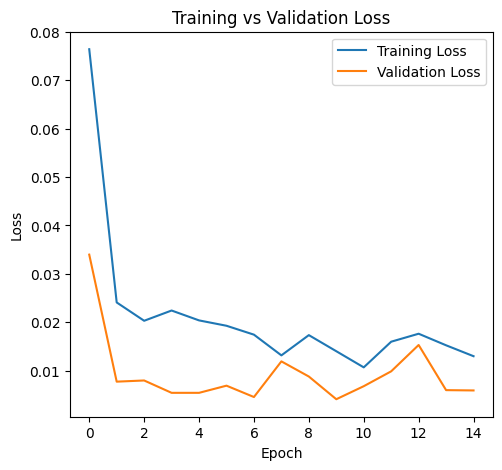

In [5]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')



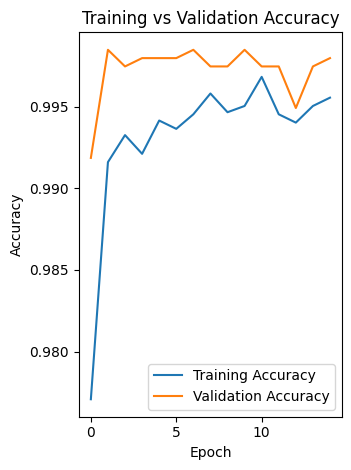

In [6]:
# Vẽ biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.tight_layout()
plt.show()

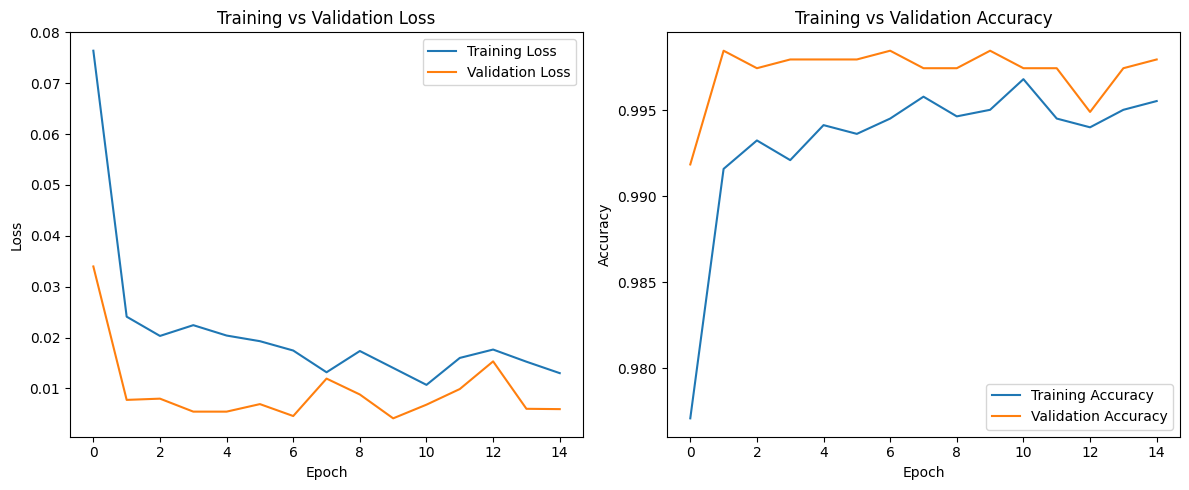

In [7]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Vẽ biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.tight_layout()
plt.show()

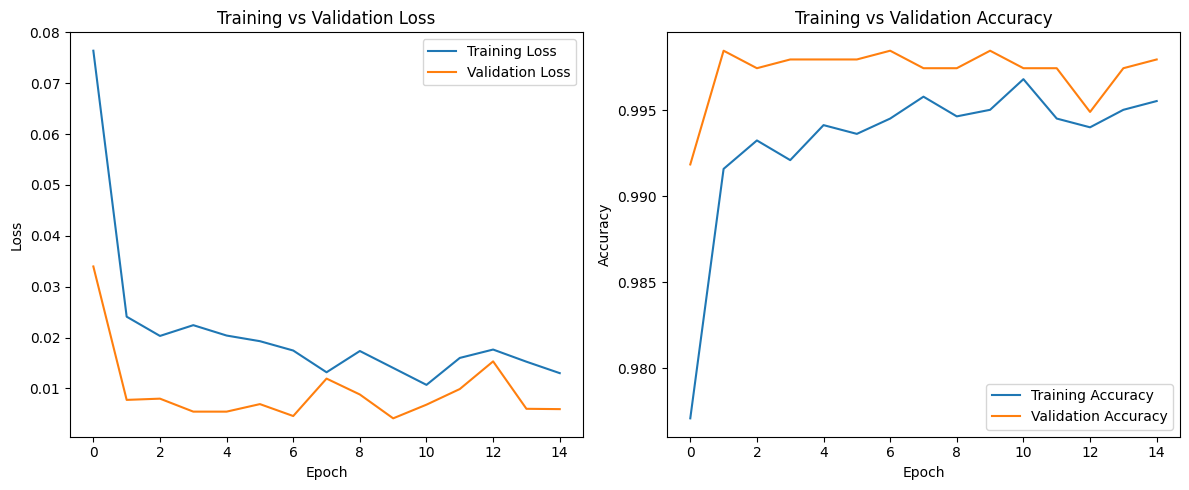

In [7]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Vẽ biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
model_inception = load_model("/kaggle/working/garbage_classification_binary_model_04.h5")

def predict_waste_category(image_path, model):
    # Load và tiền xử lý ảnh
    img = Image.open(image_path)
    img = img.resize((384, 512))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Dự đoán
    prediction = model.predict(img_array)[0][0]
    if prediction > 0.5:
        return "khong co rac ", prediction
    else:
        return "co rac ", prediction

# Ví dụ
image_path = "/kaggle/working/test_dataset/khong_co_rac/frame_20241112_103136_629482.jpg"
predicted_category, probability = predict_waste_category(image_path, model_inception)
print("Predicted category:", predicted_category)
print("Probability:", probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted category: khong co rac 
Probability: 0.9808396


Found 1965 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 337ms/step - accuracy: 0.9963 - loss: 0.0100
Validation Loss: 0.004114530049264431
Validation Accuracy: 0.9984732866287231
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step

Classification Report:
              precision    recall  f1-score   support

      co_rac       1.00      1.00      1.00      1649
khong_co_rac       0.99      1.00      1.00       316

    accuracy                           1.00      1965
   macro avg       1.00      1.00      1.00      1965
weighted avg       1.00      1.00      1.00      1965



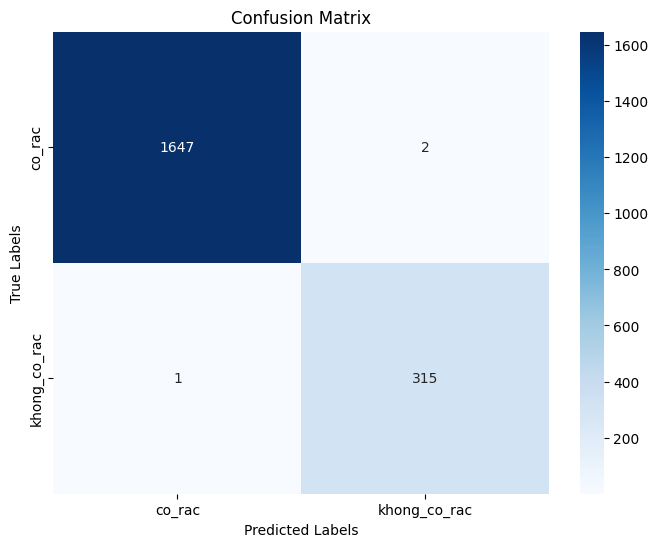

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn tới mô hình đã huấn luyện
model_path = "/kaggle/working/garbage_classification_binary_model_04.h5"  # Đổi đường dẫn thành file .h5 của bạn
model = load_model(model_path)

# Đường dẫn tới thư mục test_dataset
validation_dir = "/kaggle/working/test_dataset"  # Đổi đường dẫn thành thư mục chứa test_dataset

# Kích thước ảnh và batch size
img_height = 512
img_width = 384
batch_size = 32

# Chuẩn bị dữ liệu validation với ImageDataGenerator
validation_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập validation
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Không shuffle để đảm bảo thứ tự dữ liệu đúng
)

# Đánh giá mô hình trên tập validation
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

# Dự đoán trên tập validation
y_pred = model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)  # Chuyển đổi thành nhãn 0 hoặc 1
y_true = validation_generator.classes  # Lấy nhãn thực tế

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("\nClassification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Vẽ biểu đồ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()